In [1]:
from pathlib import Path
import random

from utils import compare_metadata, generate_plots

from librep.datasets.har.loaders import PandasMultiModalLoader


/home/patrick/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
standartized_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}

In [3]:
raw_view_path = Path("../data/processed/RealWorld/raw_balanced")
processed_view_path = Path("../data/processed/RealWorld/standartized_balanced")

train_raw, validation_raw, test_raw = PandasMultiModalLoader(raw_view_path).load(
    label="standard activity code"
)
train_processed, validation_processed, test_processed = PandasMultiModalLoader(
    processed_view_path
).load(label="standard activity code")


In [4]:
compare_metadata(
    train_raw.data,
    train_processed.data,
    ["user", "standard activity code", "window"],
)

True

In [5]:
# Pegando apenas amostras da posição waist
train_raw.data = train_raw.data[train_raw.data["position"] == "waist"].reset_index(drop=True)
validation_raw.data = validation_raw.data[validation_raw.data["position"] == "waist"].reset_index(drop=True)
test_raw.data = test_raw.data[test_raw.data["position"] == "waist"].reset_index(drop=True)

train_processed.data = train_processed.data[train_processed.data["position"] == "waist"].reset_index(drop=True)
validation_processed.data = validation_processed.data[validation_processed.data["position"] == "waist"].reset_index(drop=True)
test_processed.data = test_processed.data[test_processed.data["position"] == "waist"].reset_index(drop=True)

train_raw, train_processed

(PandasMultiModalDataset: samples=10303, features=900, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=10303, features=360, no. window=6, label_columns='standard activity code')

[133, 6025, 2331, 5556, 5982]


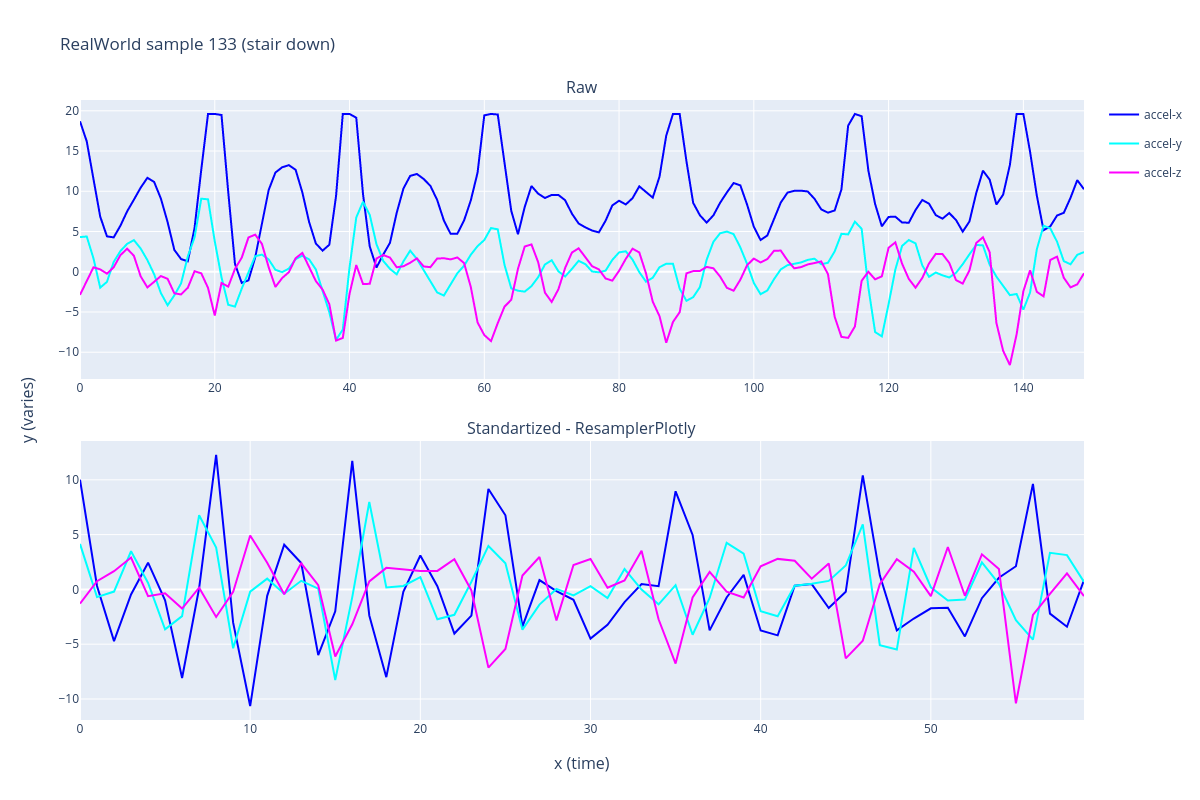

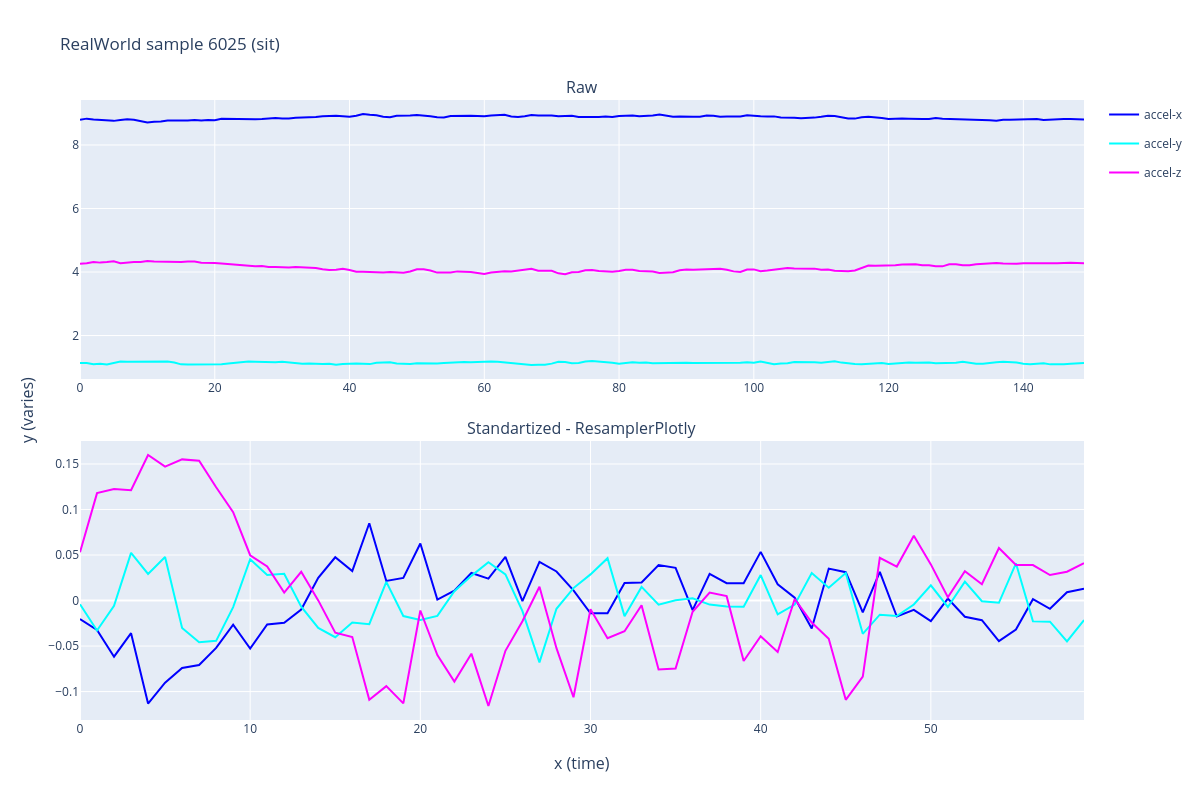

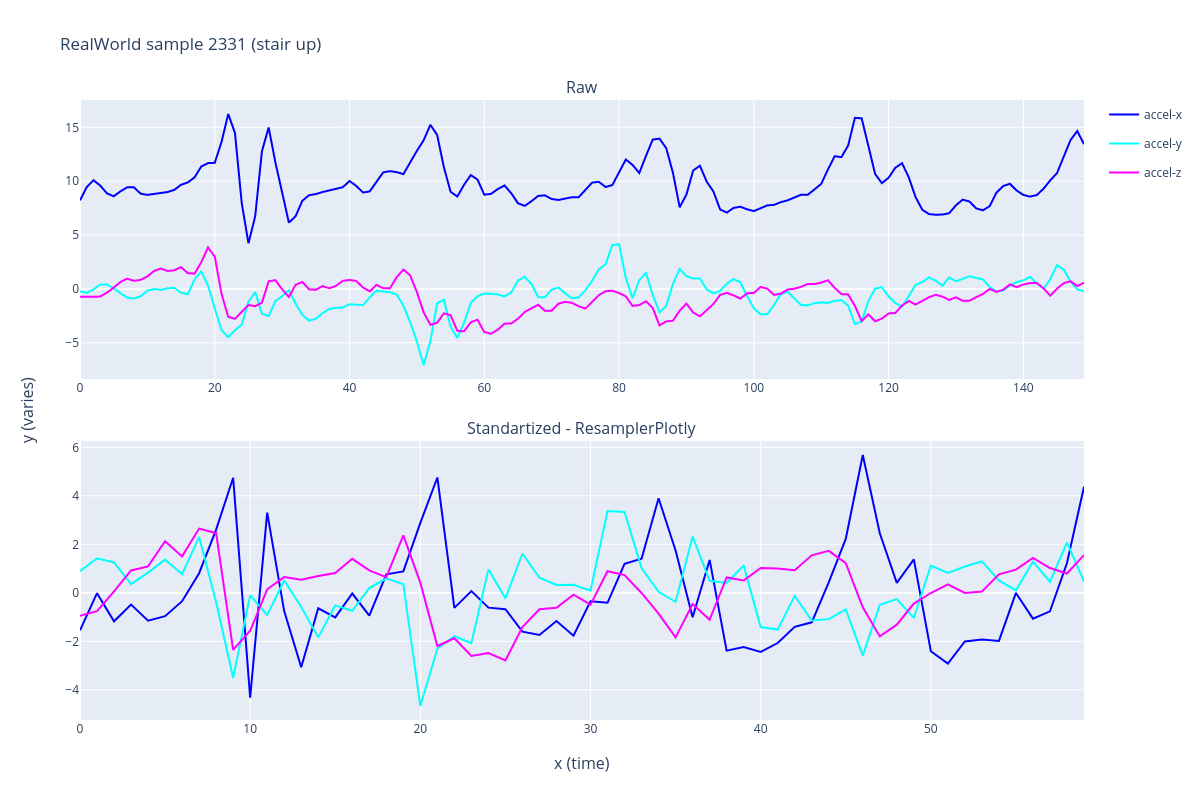

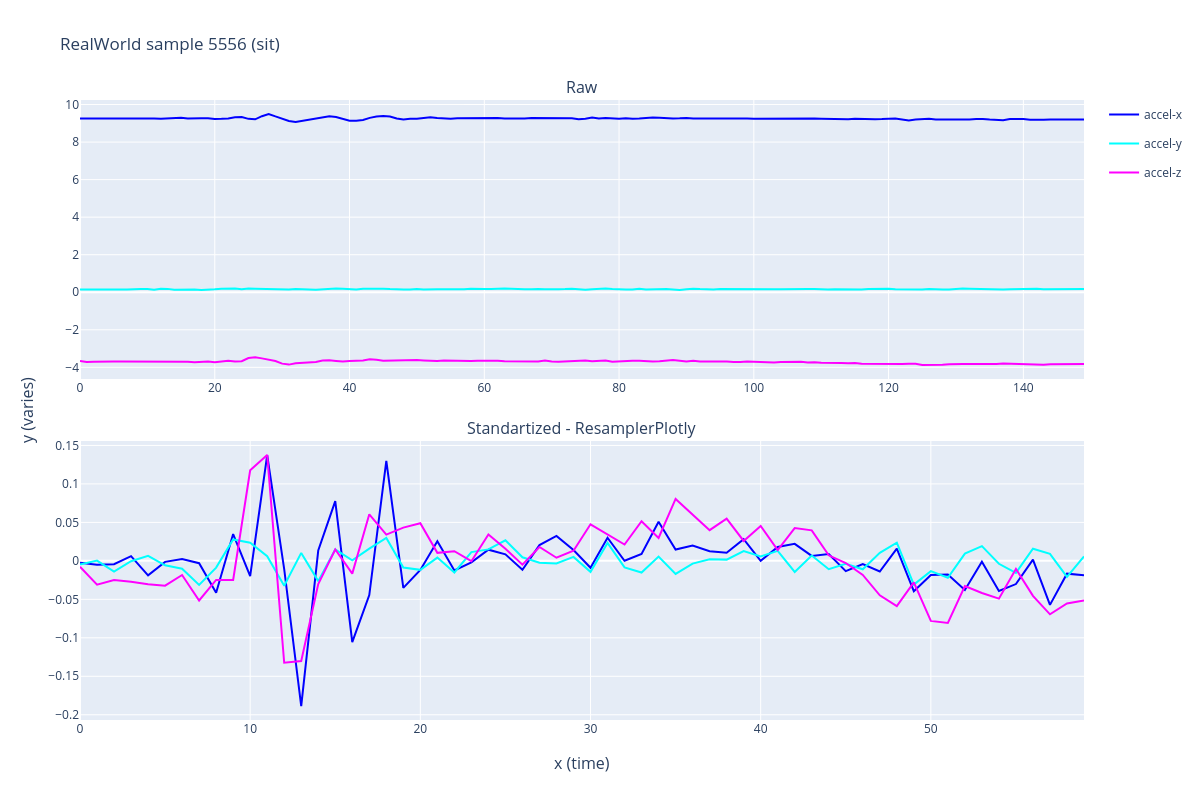

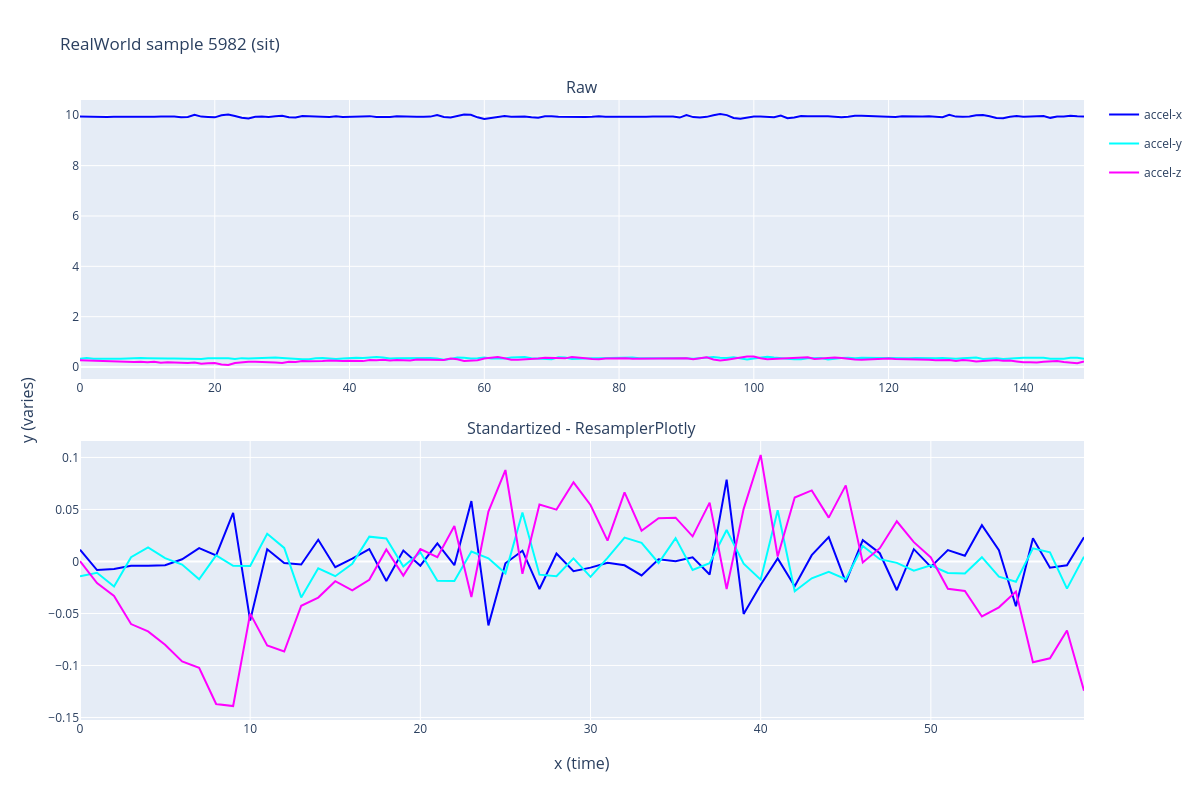

In [6]:
selected_samples = random.sample(range(len(train_raw)), 5)
print(selected_samples)

for i in selected_samples:
    label = standartized_codes[train_raw[i][1]]

    fig = generate_plots(
        train_raw,
        train_processed,
        sample_no=i,
        windows=["accel-x", "accel-y", "accel-z"],
        height=800,
        width=1200,
        names=["Raw", "Standartized - ResamplerPlotly"],
        vertical_spacing=0.1,
        title=f"RealWorld sample {i} ({label})",
        x_title="x (time)",
        y_title="y (varies)",
    )
    fig.show("png")


In [7]:
from librep.transforms.fft import FFT
from librep.datasets.multimodal.operations import DatasetWindowedTransform

transformer = DatasetWindowedTransform(transform=FFT(centered=True), do_fit=False, new_suffix=".fft")
fft_train_raw, fft_validation_raw, fft_test_raw = transformer(train_raw), transformer(validation_raw), transformer(test_raw)
fft_train_processed, fft_validation_processed, fft_test_processed = transformer(train_processed), transformer(validation_processed), transformer(test_processed)

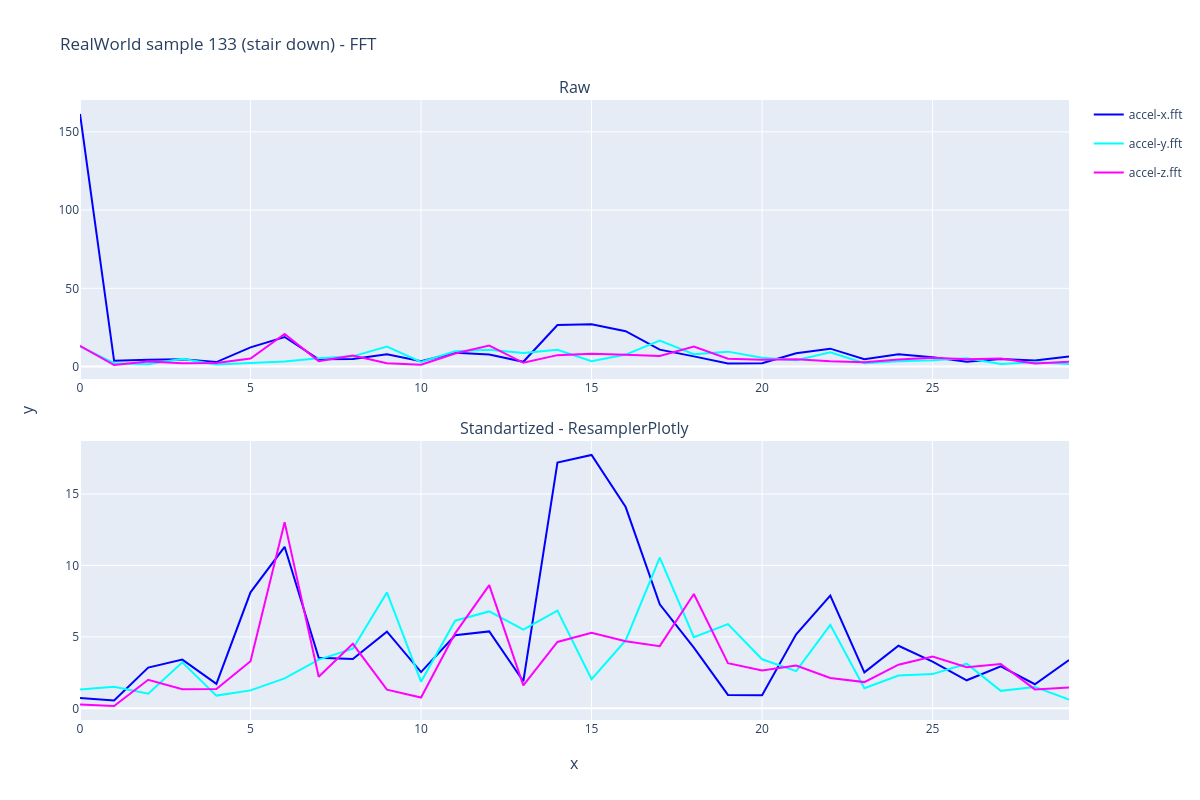

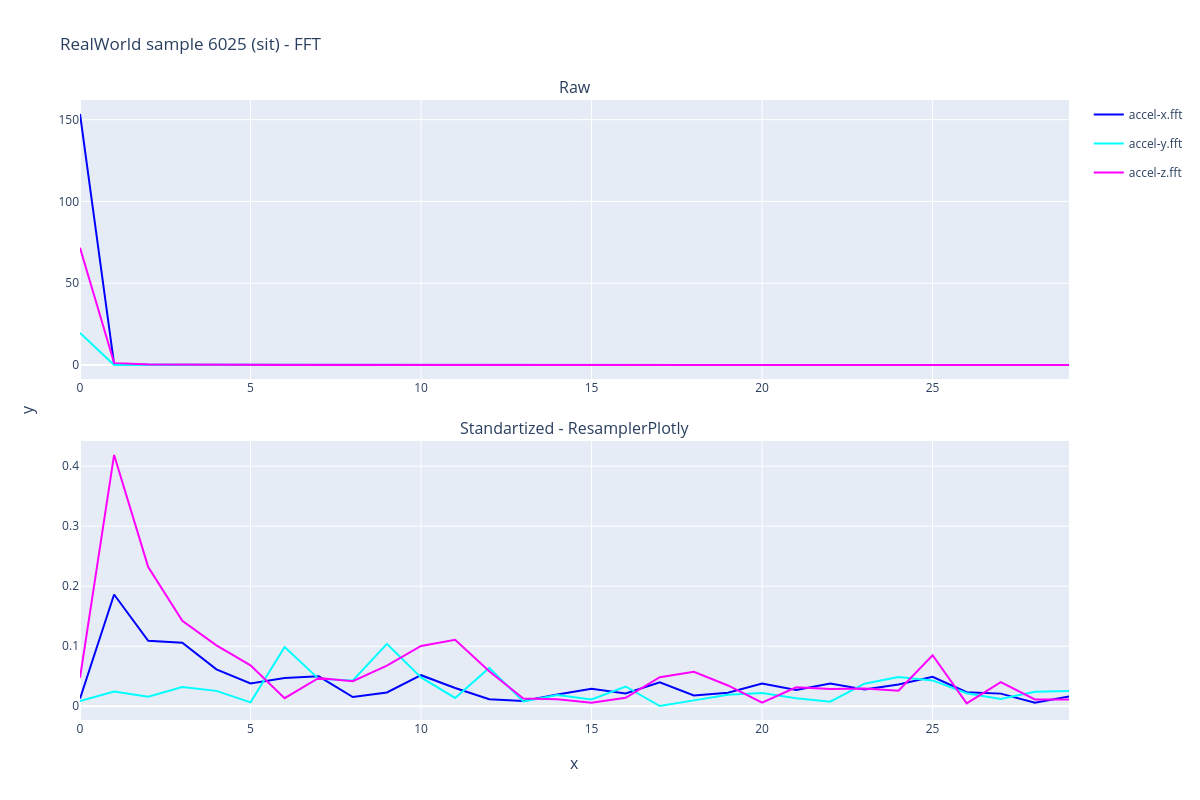

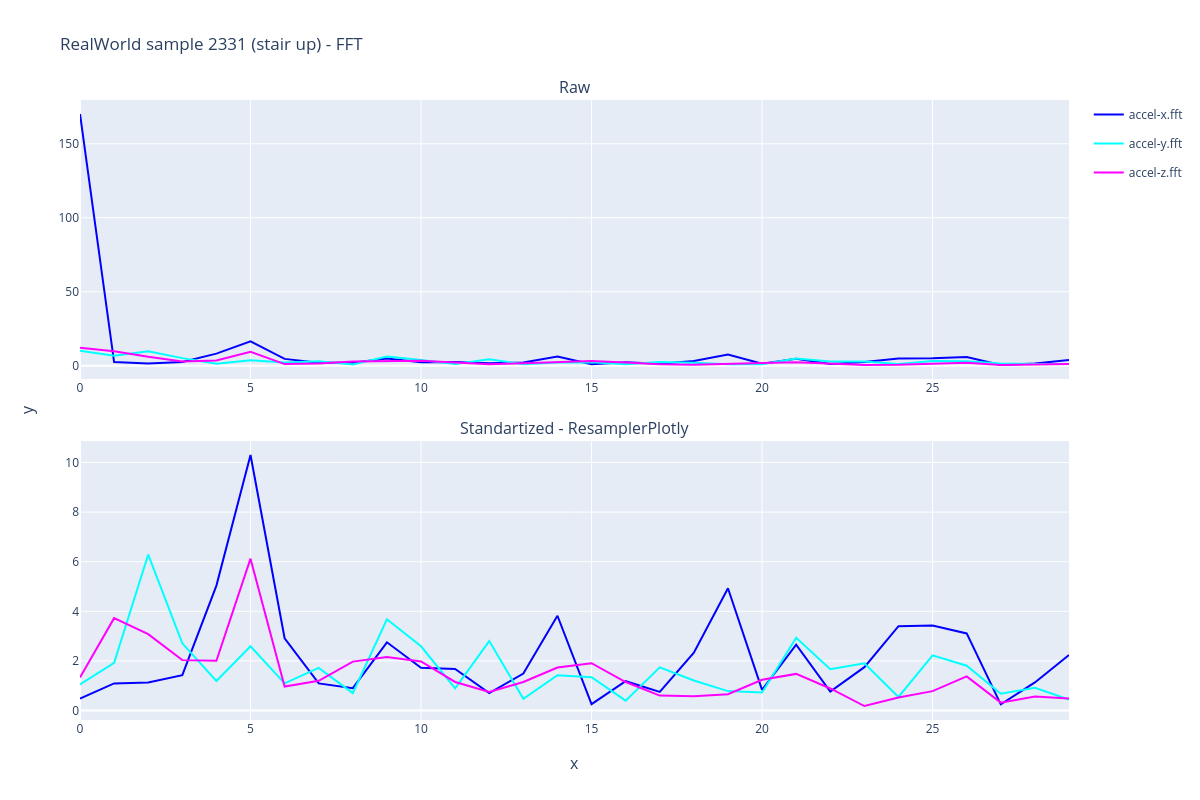

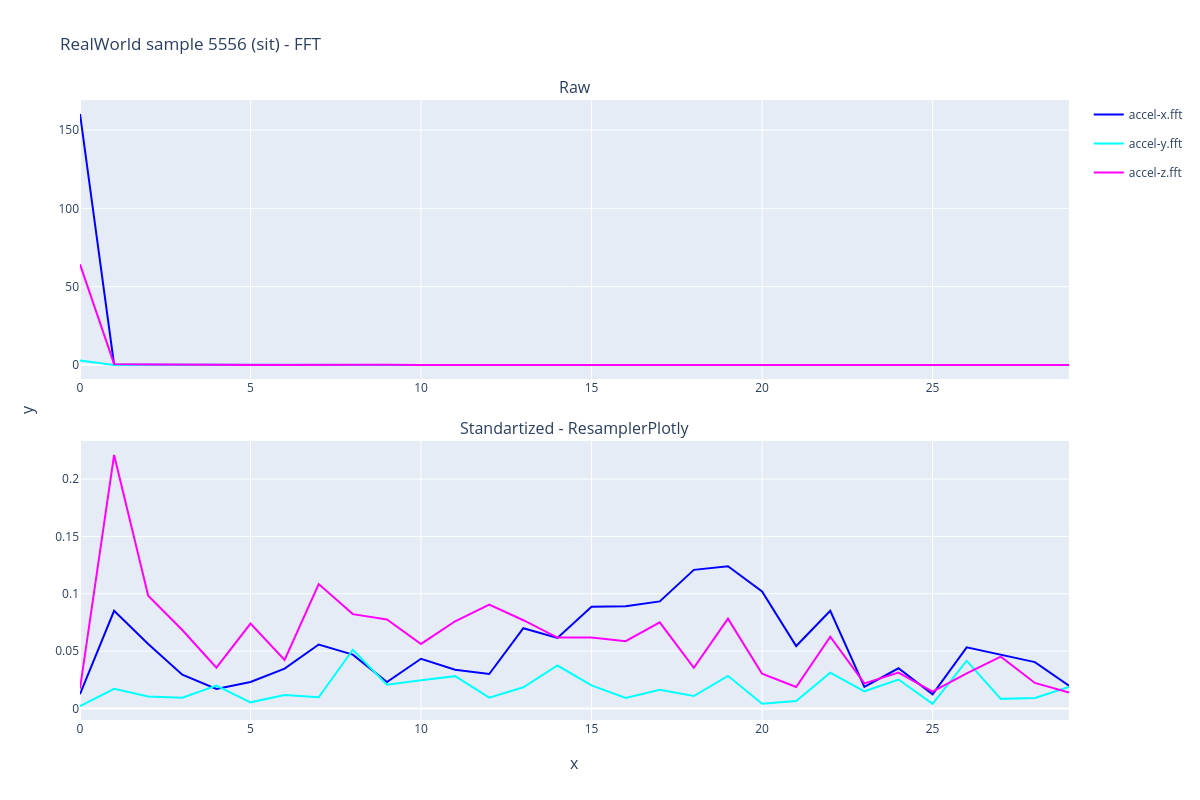

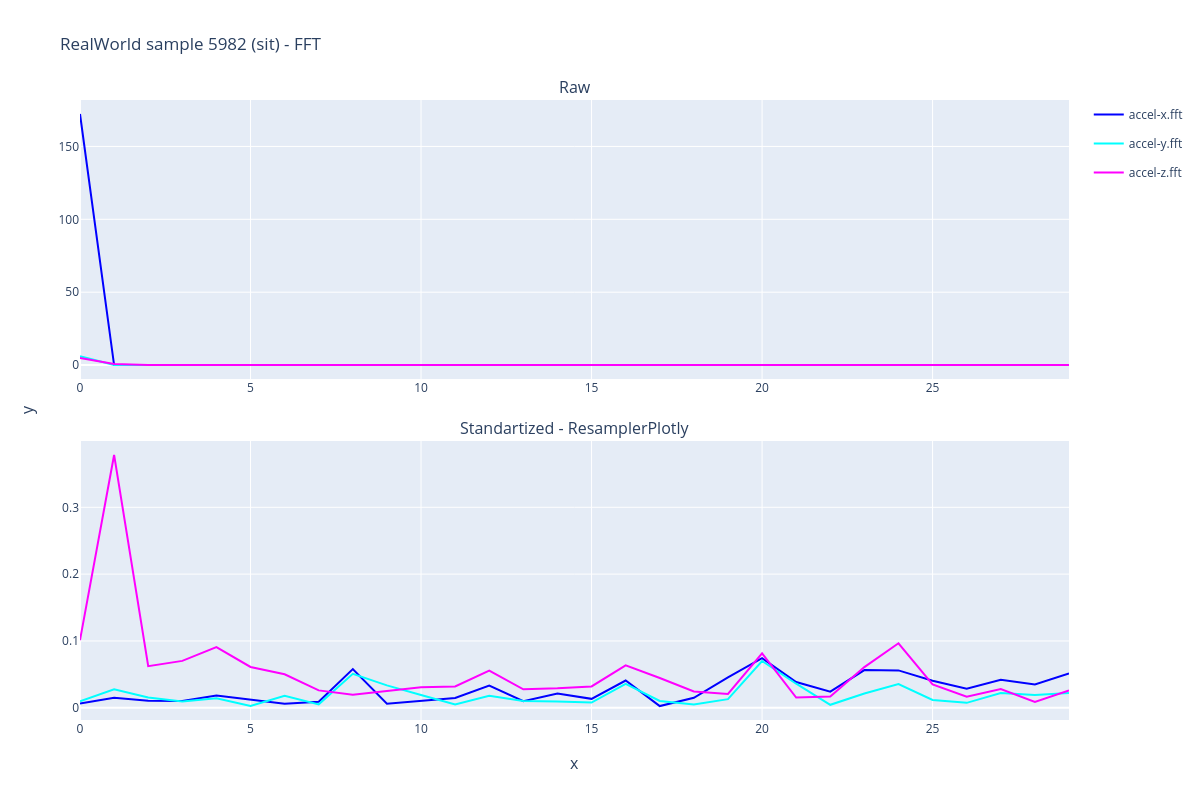

In [8]:
for i in selected_samples:
    label = standartized_codes[train_raw[i][1]]

    fig = generate_plots(
        fft_train_raw,
        fft_train_processed,
        sample_no=i,
        windows=["accel-x.fft", "accel-y.fft", "accel-z.fft"],
        height=800,
        width=1200,
        names=["Raw", "Standartized - ResamplerPlotly"],
        vertical_spacing=0.1,
        title=f"RealWorld sample {i} ({label}) - FFT",
        x_title="x",
        y_title="y",
        the_slice=slice(0, 30, 1)
    )
    fig.show("png")

In [9]:
from sklearn.ensemble import RandomForestClassifier
from umap import UMAP
from librep.datasets.multimodal.operations import (
    DatasetFitter,
    DatasetPredicter,
    DatasetY,
    DatasetEvaluator,
    DatasetTransformer,
)
from librep.metrics.report import ClassificationReport


def train_rf(train_dset, test_dset, use_umap=False):
    if use_umap:
        umap_model = UMAP(n_neighbors=5, n_components=5, metric="euclidean")
        DatasetFitter(umap_model, use_y=False)(train_dset)
        train_dset = DatasetTransformer(umap_model)(train_dset)
        test_dset = DatasetTransformer(umap_model)(test_dset)
    
    model = RandomForestClassifier()
    DatasetFitter(model, use_y=True)(train_dset)
    y_pred = DatasetPredicter(model)(test_dset)
    y_true = DatasetY()(test_dset)
    return DatasetEvaluator(ClassificationReport(normalize="all"))(y_true, y_pred)


# Classification without dimension reduction

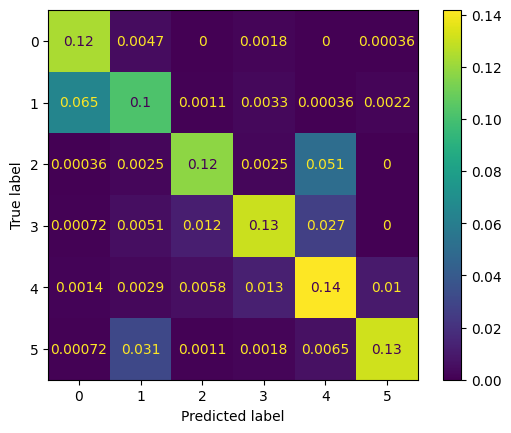

{'accuracy': 0.7471971066907775, 'f1 score (weighted)': 0.7480155282821087, 'f1 score (micro)': 0.7471971066907775, 'f1 score (macro)': 0.7489205620175862, 'confusion matrix': [[343, 13, 0, 5, 0, 1], [179, 282, 3, 9, 1, 6], [1, 7, 325, 7, 140, 0], [2, 14, 33, 360, 74, 0], [4, 8, 16, 35, 392, 28], [2, 85, 3, 5, 18, 364]]}


In [10]:
fft_train_validation_raw = fft_train_raw.concatenate(fft_validation_raw)
result = train_rf(fft_train_validation_raw, fft_test_raw)
print(result)

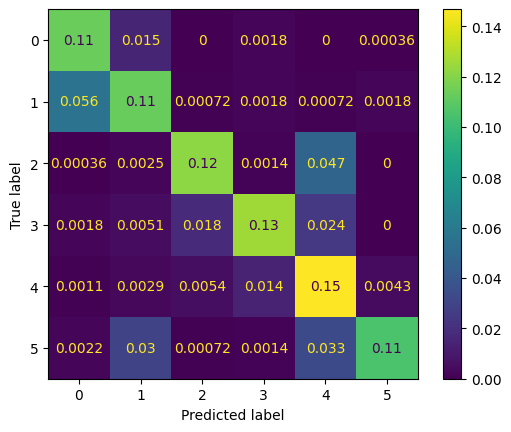

{'accuracy': 0.7258589511754069, 'f1 score (weighted)': 0.7285171929362645, 'f1 score (micro)': 0.7258589511754068, 'f1 score (macro)': 0.729079526041048, 'confusion matrix': [[314, 42, 0, 5, 0, 1], [155, 311, 2, 5, 2, 5], [1, 7, 337, 4, 131, 0], [5, 14, 49, 348, 67, 0], [3, 8, 15, 39, 406, 12], [6, 83, 2, 4, 91, 291]]}


In [11]:
fft_train_validation_processed = fft_train_processed.concatenate(fft_validation_processed)
result = train_rf(fft_train_validation_processed, fft_test_processed)
print(result)

# Classification with dimension reduction

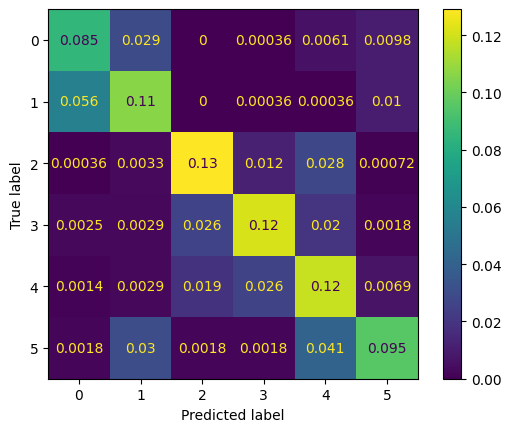

{'accuracy': 0.6556962025316456, 'f1 score (weighted)': 0.6570005164369265, 'f1 score (micro)': 0.6556962025316456, 'f1 score (macro)': 0.6551324786456121, 'confusion matrix': [[236, 81, 0, 1, 17, 27], [156, 293, 0, 1, 1, 29], [1, 9, 357, 33, 78, 2], [7, 8, 72, 336, 55, 5], [4, 8, 52, 73, 327, 19], [5, 84, 5, 5, 114, 264]]}


In [12]:
fft_train_validation_raw = fft_train_raw.concatenate(fft_validation_raw)
result = train_rf(fft_train_validation_raw, fft_test_raw, use_umap=True)
print(result)

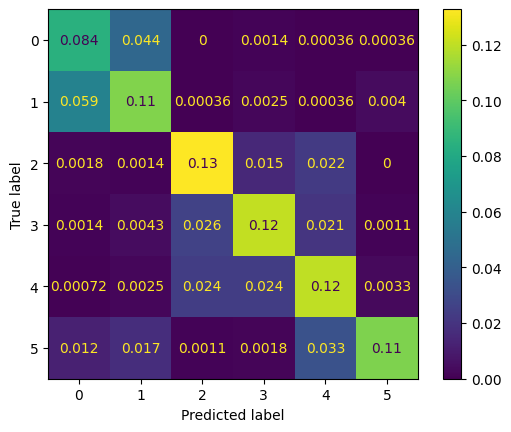

{'accuracy': 0.6726943942133815, 'f1 score (weighted)': 0.6761668218856829, 'f1 score (micro)': 0.6726943942133815, 'f1 score (macro)': 0.6723650746057723, 'confusion matrix': [[233, 123, 0, 4, 1, 1], [162, 298, 1, 7, 1, 11], [5, 4, 367, 42, 62, 0], [4, 12, 73, 334, 57, 3], [2, 7, 67, 66, 332, 9], [33, 48, 3, 5, 92, 296]]}


In [13]:
fft_train_validation_processed = fft_train_processed.concatenate(fft_validation_processed)
result = train_rf(fft_train_validation_processed, fft_test_processed,   use_umap=True)
print(result)